In [1]:
import numpy as np                                                                                     
import matplotlib.pyplot as plt                                 
import pandas as pd                                             
import geopandas as gpd                                         
import rasterio
from rasterstats import zonal_stats
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
import seaborn as sns
import os

# turns on 'nline plotting', where plot graphics will appear in the notebook below the cell that produced them.
%matplotlib inline              

# Change module setting
pd.options.display.max_colwidth = 80       # Longer text in pd.df

## Data Cleaning and Munging

In [2]:
path= 'F:/Project/2023'
os.chdir(path)

In [3]:
# reads the corn plots
plots= gpd.read_file('2023_plots/plots.shp')


# reads the SAR_optical pairs for each growing period
early_july= rasterio.open('SAR_optical/July/Early_July/16_5_stacked.tif')
late_july= rasterio.open('SAR_optical/July/Late_July/16_5_stacked.tif')
august= rasterio.open('SAR_optical/August/16_5_stacked.tif')
september= rasterio.open('SAR_optical/September/16_5_stacked.tif')

# puts them in a list for looping 
all_4= [early_july.read(), late_july.read(), august.read(), september.read()]

# Transforms pixel coordinates to x,y coordinaetes
affine= late_july.transform

In [5]:
# column names for separating the monthly data into separate dataframes and appending them row-wise
names= ['S1_ELLIP', 'S1_ORIEN', 'S1_LPR', 'S1_I2', 'S1_I1', 'S1_g3', 'S1_g2', 'S1_g1', 'S1_g0', 'S1_DoLP',
            'S1_span', 'S1_entropy_shannon', 'S1_entropy', 'S1_alpha', 'S1_C22', 'S1_C11', 'S2_NDVI', 'S2_NDRE', 'S2_NDWI', 'S2_RECI', 'S2_GCI']

# creates special column names for each month's data
el= [name + '_el' for name in names]
ll= [name + '_ll' for name in names]
au= [name + '_au' for name in names]
se= [name + '_se' for name in names]

# unpacks the names in the above lists into a new list
all_names= [*el , *ll , *au ,*se]


# column names for final training data
new_names= ['Id', 'Name', 'geometry', 'S1_ELLIP', 'S1_ORIEN', 'S1_LPR', 'S1_I2', 'S1_I1', 'S1_g3', 'S1_g2', 'S1_g1', 'S1_g0', 'S1_DoLP',
            'S1_span', 'S1_entropy_shannon', 'S1_entropy', 'S1_alpha', 'S1_C22', 'S1_C11', 'S2_NDVI', 'S2_NDRE', 'S2_NDWI', 'S2_RECI', 'S2_GCI']

In [ ]:
# finds the mean of each plot for all the 21 features
mean= []
for each in all_4:
    for band in each:
        df_mean = pd.DataFrame(zonal_stats(plots, band, affine=affine, stats= 'median'))
        median.append(df_median)

# the result of the above cells is a dataframe for each feature for each month, so this line of code appends them
median_df= pd.concat(median, axis=1)

# renames the columns and splits them based on the growing stage
median_df.columns= all_names
median_el= median_df.filter(like= '_el')
median_ll= median_df.filter(like= '_ll')
median_au= median_df.filter(like= '_au')
median_se= median_df.filter(like= '_se')

# adds median statistics of each growing stage to the plots GeoDataFrame for visualization
median_el_plots = pd.concat([plots, median_el], axis=1)
median_ll_plots = pd.concat([plots, median_ll], axis=1)
median_au_plots = pd.concat([plots, median_au], axis=1)
median_se_plots = pd.concat([plots, median_se], axis=1)

# renames the columns of all dataframes for row-wise concatenation
median_el_plots.columns= new_names
median_ll_plots.columns= new_names
median_au_plots.columns= new_names
median_se_plots.columns= new_names

# row-wise concatenation of data from each growing stage
train_pts= pd.concat([median_el_plots, median_ll_plots, median_au_plots, median_se_plots]).reset_index(drop=True).drop('Id', axis= 1)

# specifies the treatment for each plot
def Treatment_extractor(x):
    return x[0:2]

train_pts['Treatment']= train_pts['Name'].apply(Treatment_extractor)

## Exploratory Data Analysis

Text(0.5, 1.0, 'Late July NDVI')

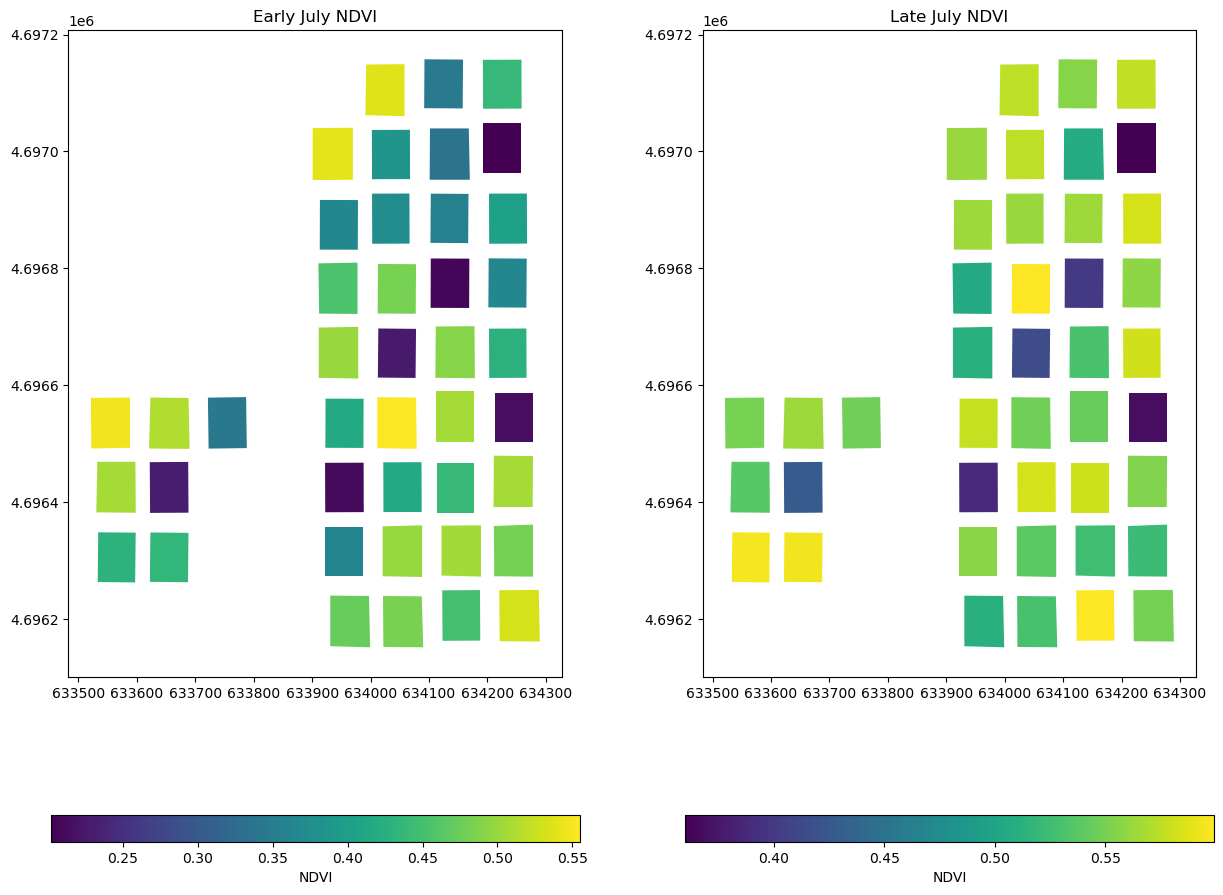

In [14]:
# splits data according to growing stage
e_july= train_pts.iloc[0:42, :]
l_july= train_pts.iloc[42:84, :]
aug= train_pts.iloc[84:126, :]
sep= train_pts.iloc[126:, :]

# plots choropleth maps of NDVI for each plot for each growing stage

# Creates 4 subplots
fig, ax = plt.subplots(nrows= 1, ncols=2, figsize=(15, 12)) 
 
# Access each axes object to plot  data
e_july.plot(column= 'S2_NDVI', ax= ax[0], legend= True, legend_kwds= {'label': 'NDVI', 'orientation': 'horizontal'}).set_title('Early July NDVI')

l_july.plot(column= 'S2_NDVI', ax= ax[1], legend= True, legend_kwds= {'label': 'NDVI', 'orientation': 'horizontal'}).set_title('Late July NDVI')

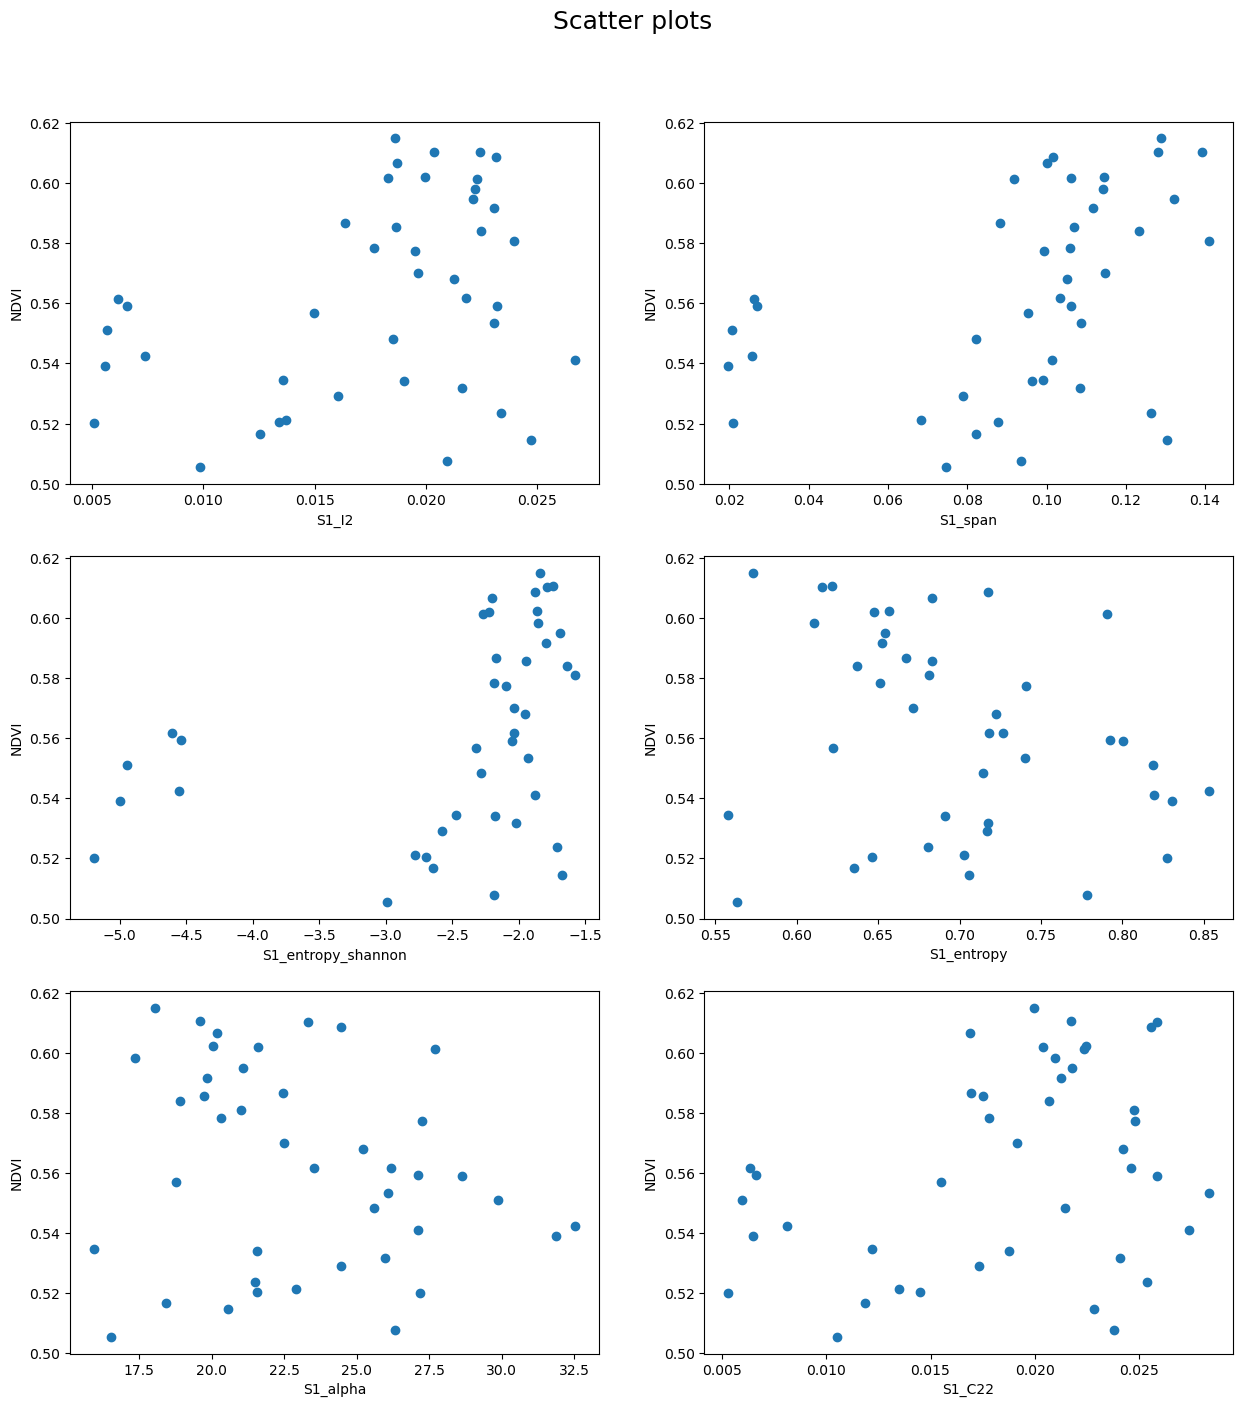

In [32]:
# selects features of interest for plotting
plotting= aug.iloc[:, [5, 12, 13, 14, 15, 16]]

# plots scatter plots of the dependent variables(any of the VIs) with some of the independent variable

# defines the subplots
fig, axs= plt.subplots(nrows=3, ncols=2, figsize= (15, 16))
fig.suptitle('Scatter plots', fontsize=18, y=0.95)

# loops through the variables and subplots
for variable, ax in zip(plotting, axs.ravel()):
    ax.scatter(x= plotting[variable], y= aug['S2_NDVI'])
    
    ax.set_xlabel(variable)
    ax.set_ylabel('NDVI')

## Modeling

### Feature selection

In [33]:
# partition features and labels
X= aug[['S1_ELLIP', 'S1_ORIEN', 'S1_LPR', 'S1_I2', 'S1_I1', 'S1_g3', 'S1_g2', 'S1_g1', 'S1_g0', 'S1_DoLP',
            'S1_span', 'S1_entropy_shannon', 'S1_entropy', 'S1_alpha', 'S1_C22', 'S1_C11']]

#x= StandardScaler().fit_transform(X)
x=X

y= aug['S2_NDVI']

[0.04460732 0.03681079 0.04462349 0.08548725 0.16431936 0.03578142
 0.03881163 0.07160425 0.09225614 0.0794623  0.06291247 0.08711501
 0.05487293 0.01971594 0.03077767 0.05084205]


<function matplotlib.pyplot.show(close=None, block=None)>

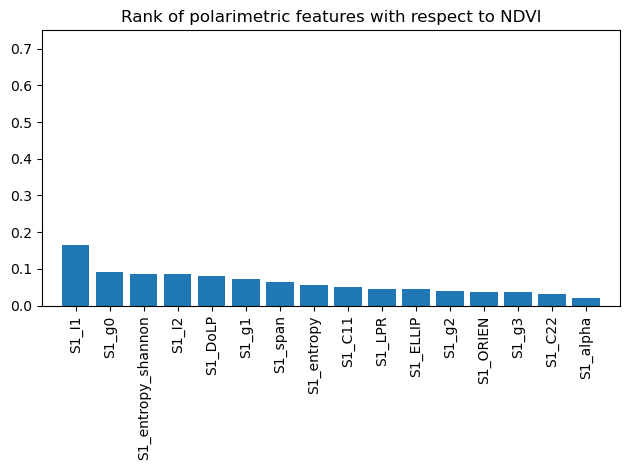

In [34]:
# initiates model
rf= RandomForestRegressor(random_state=42)
rf.fit(x,y)

# # ranks the features using the random forest (impurity) method
rf_importance= rf.feature_importances_
print(rf_importance)

# plots the importance of features in descending order for SAR data
indices= np.argsort(rf_importance)[::-1]

plt.figure()
plt.title('Rank of polarimetric features with respect to NDVI')
plt.bar(range(X.shape[1]), rf_importance[indices])
plt.xticks(range(X.shape[1]), X.iloc[:,:].columns[indices], rotation= 90)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.75])
plt.tight_layout()
plt.show

In [23]:
kf = KFold(n_splits=5, shuffle= True, random_state= 42)

In [35]:
# selects the best features using sequential feature selection
SFS2 = SequentialFeatureSelector(rf, 
           k_features= 'best', 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='r2',
           cv=kf)


SFS2 = SFS2.fit(x, y)

In [36]:
# prints the selected features from mlxtend
X.columns[list(SFS2.k_feature_idx_)]

Index(['S1_LPR', 'S1_g1', 'S1_alpha'], dtype='object')

In [37]:
# creates a dataframe of r2 scores from different feature combination
metric_dict = SFS2.get_metric_dict(confidence_interval=0.95)
SFS2_df = pd.DataFrame(metric_dict).T
SFS2_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(7,)","[0.36567538840055014, 0.43306234634089225, -0.9795857887834183, 0.0275397865...",0.111168,"(S1_g1,)",0.754436,0.586977,0.293488
2,"(2, 7)","[0.590101353793167, 0.5252550960485167, -0.681959008077627, 0.03460615561192...",0.130353,"(S1_LPR, S1_g1)",0.585954,0.455892,0.227946
3,"(2, 7, 13)","[0.6157383939411565, 0.41702417499171074, -0.5938093317656945, 0.09474606913...",0.179793,"(S1_LPR, S1_g1, S1_alpha)",0.541173,0.421051,0.210526
4,"(2, 7, 12, 13)","[0.5833025041810531, 0.3004104699932678, -0.4038013392242428, 0.029896515314...",0.172907,"(S1_LPR, S1_g1, S1_entropy, S1_alpha)",0.434263,0.337871,0.168936
5,"(2, 7, 9, 12, 13)","[0.5552943953950675, 0.31081299046503363, -0.5332609126369117, 0.02834734577...",0.15459,"(S1_LPR, S1_g1, S1_DoLP, S1_entropy, S1_alpha)",0.494521,0.384754,0.192377
6,"(2, 3, 7, 9, 12, 13)","[0.5579573503652345, 0.4260239593405901, -0.6109318719623549, -0.05859994433...",0.095464,"(S1_LPR, S1_I2, S1_g1, S1_DoLP, S1_entropy, S1_alpha)",0.530078,0.412418,0.206209
7,"(2, 3, 6, 7, 9, 12, 13)","[0.45591579121105785, 0.34307988518366506, -0.3915462670727097, -0.092778681...",0.070819,"(S1_LPR, S1_I2, S1_g2, S1_g1, S1_DoLP, S1_entropy, S1_alpha)",0.391521,0.304617,0.152308
8,"(1, 2, 3, 6, 7, 9, 12, 13)","[0.5021386923850515, 0.36193211655375523, -0.43410609094902064, -0.101430389...",0.066202,"(S1_ORIEN, S1_LPR, S1_I2, S1_g2, S1_g1, S1_DoLP, S1_entropy, S1_alpha)",0.430128,0.334654,0.167327
9,"(1, 2, 3, 6, 7, 9, 11, 12, 13)","[0.40656559471926423, 0.38857834089021337, -0.5913290112537009, -0.217392450...",0.028664,"(S1_ORIEN, S1_LPR, S1_I2, S1_g2, S1_g1, S1_DoLP, S1_entropy_shannon, S1_entr...",0.492361,0.383074,0.191537
10,"(0, 1, 2, 3, 6, 7, 9, 11, 12, 13)","[0.25028642394401324, 0.38871544139490244, -0.4859189378768969, -0.367635736...",0.007219,"(S1_ELLIP, S1_ORIEN, S1_LPR, S1_I2, S1_g2, S1_g1, S1_DoLP, S1_entropy_shanno...",0.462555,0.359883,0.179942
